# Traffic Light Detection and Classification - Udacity CarND Capstone
Using a pre-trained model to detect objects in an image.

In [1]:
import numpy as np
import os
import sys
import shutil
import tensorflow as tf
import time

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

# Used for image processing and manipulations
import cv2

# Used for internal storage
import pickle

# Used for data augmentation
from skimage import exposure
from skimage import util

# Used for dividing the data into training and testing
import pandas as pd
from random import seed
from random import random

from glob import glob

## Object detection imports

Here are the imports from the object detection module.

In [2]:
PATH_TO_ROOT = r'C:/Users/saidz/git/CarND-Capstone/tl_detection_pipeline/'
PATH_TO_OUTPUT = r'C:/Users/saidz/git/CarND-Capstone/tl_detection_pipeline/annotation/'
PATH_TO_API = r'C:/Users/saidz/tensorflow/models/research'

sys.path.append(PATH_TO_API)
sys.path.append(PATH_TO_API + '/object_detection')

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

## Model preparation

In [3]:
PATH_TO_LABELS = r'annotation_pipeline/mscoco_label_map.pbtxt'
NUM_CLASSES = 90

os.chdir(PATH_TO_ROOT)

M = "FRCNN" # More accurate labeling
M = "INCEPTION" # Fast labeling, but misses

if (M == "FRCNN"):
    try:
        shutil.rmtree('annotation_pipeline/pretrained/reextracted_frozen_frcnn')
    except OSError as e:
        print ("New frozen file will be generated in pretrained/reextracted_frozen_frcnn.")

    !python C:/Users/saidz/tensorflow/models/research/object_detection/export_inference_graph.py \
        --pipeline_config_path=pretrained/annotation_config/faster_rcnn_resnet101_coco.config \
        --trained_checkpoint_prefix=pretrained/faster_rcnn_resnet101_coco_2018_01_28/model.ckpt \
        --output_directory=pretrained/reextracted_frozen_frcnn/
    PATH_TO_MODEL = PATH_TO_ROOT + r'pretrained/reextracted_frozen_frcnn/frozen_inference_graph.pb'
elif (M == "INCEPTION"):
    try:
        shutil.rmtree('annotation_pipeline/pretrained/reextracted_frozen_inception')
    except OSError as e:
        print ("New frozen file will be generated in pretrained/reextracted_frozen_inception.")
        
    !python c:/users/saidz/tensorflow/models/research/object_detection/export_inference_graph.py \
        --pipeline_config_path=pretrained/annotation_config/ssd_inception_v2_coco.config \
        --trained_checkpoint_prefix=pretrained/ssd_inception_v2_coco_2018_01_28/model.ckpt \
        --output_directory=pretrained/reextracted_frozen_inception/
    PATH_TO_MODEL = PATH_TO_ROOT + r'pretrained/reextracted_frozen_inception/frozen_inference_graph.pb'


New frozen file will be generated in pretrained/reextracted_frozen_inception.
Converted 410 variables to const ops.


Instructions for updating:
Please switch to tf.train.get_or_create_global_step
2019-12-09 00:40:25.431960: I C:\tf_jenkins\home\workspace\rel-win\M\windows\PY\35\tensorflow\core\platform\cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX AVX2
2019-12-09 00:40:32.958250: I C:\tf_jenkins\home\workspace\rel-win\M\windows\PY\35\tensorflow\core\grappler\devices.cc:51] Number of eligible GPUs (core count >= 8): 0
Traceback (most recent call last):
  File "c:/users/saidz/tensorflow/models/research/object_detection/export_inference_graph.py", line 119, in <module>
    tf.app.run()
  File "C:\Users\saidz\Miniconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\platform\app.py", line 48, in run
    _sys.exit(main(_sys.argv[:1] + flags_passthrough))
  File "c:/users/saidz/tensorflow/models/research/object_detection/export_inference_graph.py", line 115, in main
    FLAGS.output_directory, input_shape)
  File "C:\Users\saidz\tens

In [4]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bicycle'}, 3: {'id': 3, 'name': 'car'}, 4: {'id': 4, 'name': 'motorcycle'}, 5: {'id': 5, 'name': 'airplane'}, 6: {'id': 6, 'name': 'bus'}, 7: {'id': 7, 'name': 'train'}, 8: {'id': 8, 'name': 'truck'}, 9: {'id': 9, 'name': 'boat'}, 10: {'id': 10, 'name': 'traffic light'}, 11: {'id': 11, 'name': 'fire hydrant'}, 13: {'id': 13, 'name': 'stop sign'}, 14: {'id': 14, 'name': 'parking meter'}, 15: {'id': 15, 'name': 'bench'}, 16: {'id': 16, 'name': 'bird'}, 17: {'id': 17, 'name': 'cat'}, 18: {'id': 18, 'name': 'dog'}, 19: {'id': 19, 'name': 'horse'}, 20: {'id': 20, 'name': 'sheep'}, 21: {'id': 21, 'name': 'cow'}, 22: {'id': 22, 'name': 'elephant'}, 23: {'id': 23, 'name': 'bear'}, 24: {'id': 24, 'name': 'zebra'}, 25: {'id': 25, 'name': 'giraffe'}, 27: {'id': 27, 'name': 'backpack'}, 28: {'id': 28, 'name': 'umbrella'}, 31: {'id': 31, 'name': 'handbag'}, 32: {'id': 32, 'name': 'tie'}, 33: {'id': 33, 'name': 'suitcase'}, 34: {'id': 34, 'name'

In [5]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_MODEL, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [7]:
print("detection_model.image_tensor: ")
print(detection_graph.get_tensor_by_name('image_tensor:0'), "\n")
print("detection_model.detection_boxes: ")
print(detection_graph.get_tensor_by_name('detection_boxes:0'), "\n")
print("detection_model.detection_scores: ")
print(detection_graph.get_tensor_by_name('detection_scores:0'), "\n")
print("detection_model.detection_classes: ")
print(detection_graph.get_tensor_by_name('detection_classes:0'), "\n")
print("detection_model.num_detections: ")
print(detection_graph.get_tensor_by_name('num_detections:0'), "\n")

detection_model.image_tensor: 
Tensor("image_tensor:0", shape=(?, ?, ?, 3), dtype=uint8) 

detection_model.detection_boxes: 
Tensor("detection_boxes:0", dtype=float32) 

detection_model.detection_scores: 
Tensor("detection_scores:0", dtype=float32) 

detection_model.detection_classes: 
Tensor("detection_classes:0", dtype=float32) 

detection_model.num_detections: 
Tensor("num_detections:0", dtype=float32) 



In [8]:
PATH_TO_TEST_IMAGES_DIR = 'C:/Users/saidz/git/TrafficLight_Detection-TensorFlowAPI/test_images_sim/'
PATH_TO_TEST_IMAGES_DIR = 'annotation_pipeline/raw-images-simulation/'

print(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*/*.jpg'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*/*.jpg'))
print("Length of test images:", len(TEST_IMAGE_PATHS))

annotation_pipeline/raw-images-simulation/*/*.jpg
Length of test images: 96


Number 0 out of 96, file name: annotation_pipeline/raw-images-simulation\green\left0541.jpg
Number 1 out of 96, file name: annotation_pipeline/raw-images-simulation\green\left0542.jpg
Number 2 out of 96, file name: annotation_pipeline/raw-images-simulation\green\left0543.jpg
Number 3 out of 96, file name: annotation_pipeline/raw-images-simulation\green\left0544.jpg
Number 4 out of 96, file name: annotation_pipeline/raw-images-simulation\green\left0545.jpg
Number 5 out of 96, file name: annotation_pipeline/raw-images-simulation\green\left0546.jpg
Number 6 out of 96, file name: annotation_pipeline/raw-images-simulation\green\left0547.jpg
Number 7 out of 96, file name: annotation_pipeline/raw-images-simulation\green\left0548.jpg
Number 8 out of 96, file name: annotation_pipeline/raw-images-simulation\green\left0549.jpg
Number 9 out of 96, file name: annotation_pipeline/raw-images-simulation\green\left0551.jpg
Number 10 out of 96, file name: annotation_pipeline/raw-images-simulation\green\

Number 89 out of 96, file name: annotation_pipeline/raw-images-simulation\yellow\left0581.jpg
Number 90 out of 96, file name: annotation_pipeline/raw-images-simulation\yellow\left0582.jpg
Number 91 out of 96, file name: annotation_pipeline/raw-images-simulation\yellow\left0584.jpg
Number 92 out of 96, file name: annotation_pipeline/raw-images-simulation\yellow\left0585.jpg
Number 93 out of 96, file name: annotation_pipeline/raw-images-simulation\yellow\left0586.jpg
Number 94 out of 96, file name: annotation_pipeline/raw-images-simulation\yellow\left0587.jpg
Number 95 out of 96, file name: annotation_pipeline/raw-images-simulation\yellow\left0589.jpg


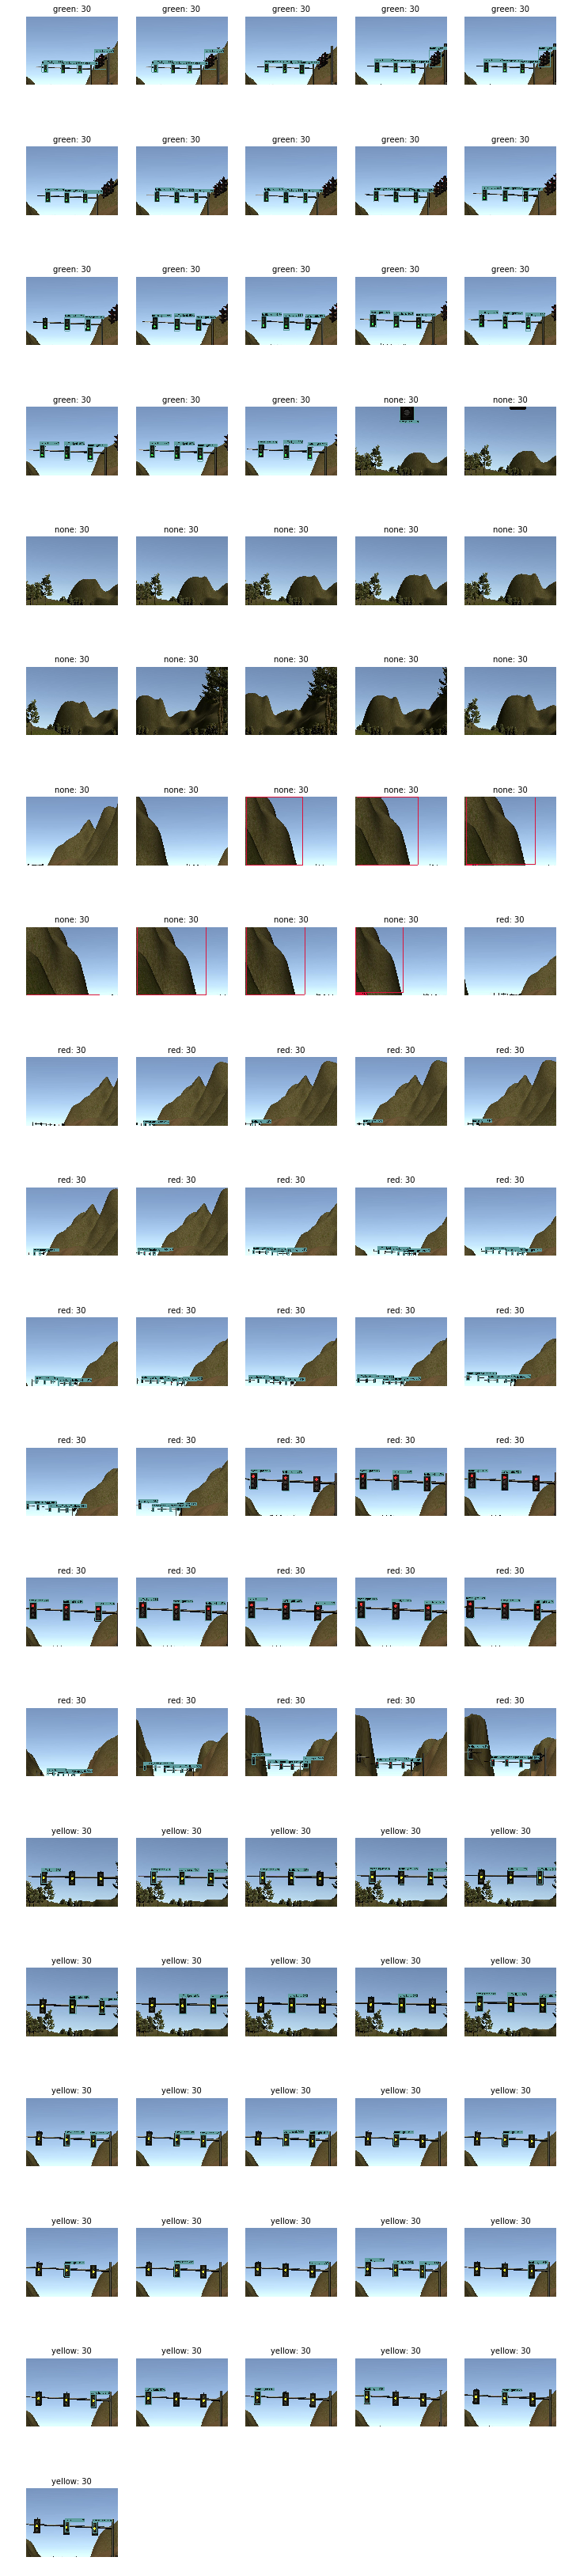

In [9]:
output_dict =[]
rows = len(TEST_IMAGE_PATHS) // 5 + 1
fig = plt.figure(figsize=(12,3*rows))

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for icount in range(len(TEST_IMAGE_PATHS)):
            print('Number {} out of {}, file name: {}'.format(icount, len(TEST_IMAGE_PATHS), TEST_IMAGE_PATHS[icount]))
            image_path = TEST_IMAGE_PATHS[icount]
            image = Image.open(image_path)

            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            color = str(TEST_IMAGE_PATHS[icount]).replace('\\','/').split('/')[-2]

            output_dict.append({'path': str(TEST_IMAGE_PATHS[icount]).replace('\\','/'), 'color': color, \
                                'boxes': boxes, 'scores': scores, 'classes': classes})
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)

            ax = plt.subplot(rows,5,len(output_dict))
            ax.imshow(image_np)
            ax.set_title("{}: {}".format(color, len(output_dict[icount]['boxes'])), fontsize=10)
            ax.axis("off")
                    
plt.show()
pickle.dump(output_dict, open(PATH_TO_ROOT + '/annotation_pipeline/' + 'annotations' + '.p', 'wb')) 

In [10]:
def filter_annotations(annotation, image_path, show_image=False):
    output={}
    output["file_name"] = annotation["path"]
    output["color"] = annotation["color"]
    output["boxes"] =[]
    output["flipped_boxes"] =[]
    image = plt.imread(output["file_name"])
#     image = cv2.resize(image,(300, 300))
    flipped_image = cv2.flip(image, 1)

    y_scale = image.shape[0]
    x_scale = image.shape[1]
    print(image.shape)

    boxed_image = image
    boxed_flipped_image = flipped_image
    print(len(annotation["boxes"]))
    for i in range(len(annotation["boxes"])):
        box = annotation["boxes"][i]
        start_point = (int(x_scale*box[1]), int(y_scale*box[0]))
        end_point = (int(x_scale*box[3]), int(y_scale*box[2]))
        flipped_start_point = (int(x_scale*(1-box[1])), int(y_scale*box[0]))
        flipped_end_point = (int(x_scale*(1-box[3])), int(y_scale*box[2]))
        height = end_point[1] - start_point[1]
        width  = end_point[0] - start_point[0]
        img = image[start_point[1]:end_point[1], start_point[0]:end_point[0], :]
        imshape = img.shape
        imsize = imshape[0] * imshape[1]
        
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        
        # color range
        lower_red1 = np.array([0,100,100])
        upper_red1 = np.array([10,255,255])
        lower_red2 = np.array([160,100,100])
        upper_red2 = np.array([180,255,255])
        lower_green = np.array([40,50,50])
        upper_green = np.array([90,255,255])
        # lower_yellow = np.array([15,100,100])
        # upper_yellow = np.array([35,255,255])
        lower_yellow = np.array([15,150,150])
        upper_yellow = np.array([35,255,255])
        mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
        maskg = cv2.inRange(hsv, lower_green, upper_green)
        masky = cv2.inRange(hsv, lower_yellow, upper_yellow)
        maskr = cv2.add(mask1, mask2)
        
        #print("Red: {}, Green: {}, Yellow: {}".format(maskr.shape, maskg.shape, masky.shape))
        #print("Size: {}, Red: {}, Green: {}, Yellow: {}".format(imsize, (maskr>0).sum(), (maskg>0).sum(), (masky>0).sum()))
        
        r_size = (maskr>0).sum() # ((maskr>0) * (maskg==0) * (masky == 0)).sum()
        g_size = (maskg>0).sum()
        y_size = (masky>0).sum()
        
        most_color = ""
        if (r_size > max(imsize/50, g_size, y_size)):
            most_color = 'red'
        elif (g_size > max(imsize/50, r_size, y_size)):
            most_color = 'green'
        elif (y_size > max(imsize/50, g_size, r_size)):
            most_color = 'yellow'

        aspect_ratio = height/width
        x_ratio = width / x_scale
        y_ratio = height / y_scale
        if (aspect_ratio > 1.5) and (aspect_ratio < 10) and (annotation['scores'][i] > 0.2) and \
            (x_ratio < 1/6) and (y_ratio < 1/2) :
            if ((most_color == annotation["color"]) or (len(annotation["boxes"]) == 1)):
                #print("Aspect ratio: {}, x_ratio: {}, y_ratio: {}, Score: {}".format(aspect_ratio, x_ratio, y_ratio, annotation['detection_scores'][i]))
        
                output["boxes"].append([start_point,end_point])
                output["flipped_boxes"].append([flipped_start_point,flipped_end_point])
                boxed_image = cv2.rectangle(boxed_image,start_point,end_point,(255,255,255),2)
                boxed_flipped_image = cv2.rectangle(boxed_flipped_image,flipped_start_point,flipped_end_point,(255,255,255),2)
    if (show_image):
        fig = plt.figure(figsize=(6,3))
        ax = plt.subplot(1,2,1)
        ax.imshow(boxed_image)   
        ax.axis("off")
        ax = plt.subplot(1,2,2)
        ax.imshow(boxed_flipped_image)
        ax.axis("off")
        plt.show()
        print(output["boxes"])
    return output


(600, 800, 3)
30


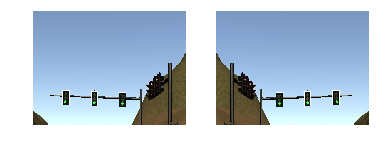

[[(304, 425), (338, 501)], [(153, 420), (189, 495)], [(444, 429), (476, 501)], [(454, 429), (486, 501)]]
(600, 800, 3)
30


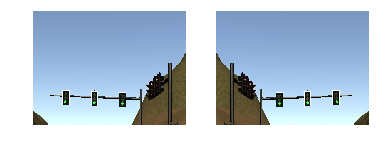

[[(304, 425), (338, 501)], [(153, 420), (189, 495)], [(444, 429), (476, 501)], [(454, 429), (486, 501)]]
(600, 800, 3)
30


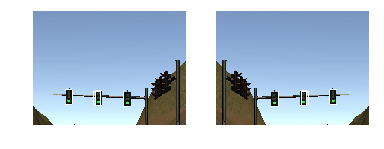

[[(474, 423), (513, 503)], [(167, 415), (205, 492)], [(326, 420), (361, 499)], [(317, 424), (352, 495)]]
(600, 800, 3)
30


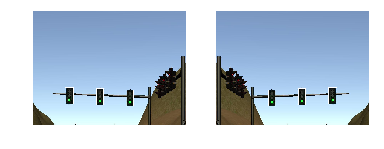

[[(333, 408), (369, 495)], [(486, 416), (524, 501)], [(166, 403), (212, 490)]]
(600, 800, 3)
30


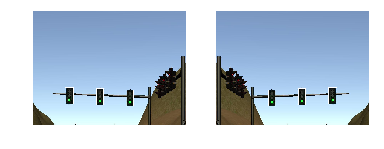

[[(333, 408), (369, 495)], [(486, 416), (524, 501)], [(166, 403), (212, 490)]]
(600, 800, 3)
30


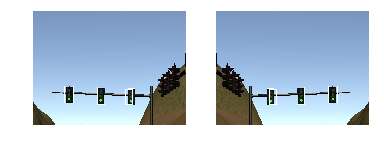

[[(165, 395), (212, 484)], [(496, 410), (532, 495)], [(336, 402), (377, 492)], [(483, 414), (519, 494)]]
(600, 800, 3)
30


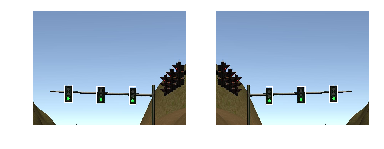

[[(164, 390), (205, 482)], [(503, 400), (539, 494)], [(332, 398), (377, 491)]]
(600, 800, 3)
30


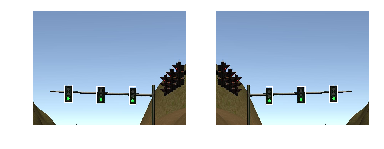

[[(164, 390), (205, 482)], [(503, 400), (539, 494)], [(332, 398), (377, 491)]]
(600, 800, 3)
30


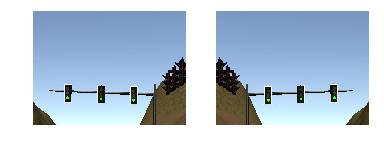

[[(164, 387), (203, 482)], [(336, 391), (377, 484)], [(509, 398), (546, 491)]]
(600, 800, 3)
30


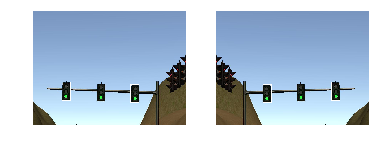

[[(508, 387), (553, 482)], [(335, 381), (377, 480)], [(152, 376), (196, 473)]]
(600, 800, 3)
30


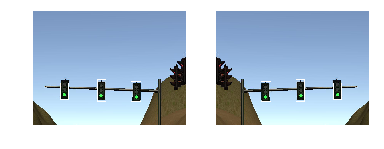

[[(512, 374), (564, 476)], [(336, 362), (381, 477)], [(143, 381), (186, 466)]]
(600, 800, 3)
30


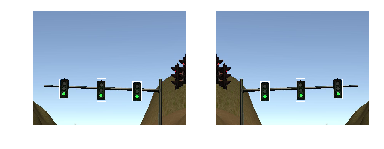

[[(521, 373), (568, 475)], [(334, 357), (381, 476)], [(137, 359), (187, 464)]]
(600, 800, 3)
30


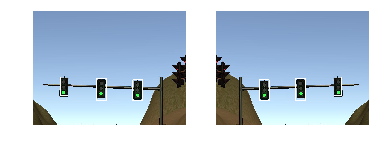

[[(143, 350), (183, 447)], [(331, 357), (384, 471)], [(521, 363), (572, 473)]]
(600, 800, 3)
30


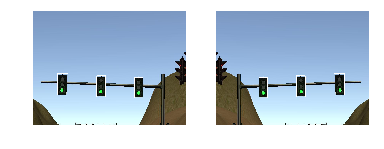

[[(333, 342), (380, 454)], [(530, 352), (574, 459)], [(128, 331), (182, 444)]]
(600, 800, 3)
30


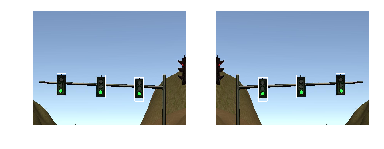

[[(335, 339), (378, 459)], [(124, 331), (172, 442)], [(531, 351), (577, 476)]]
(600, 800, 3)
30


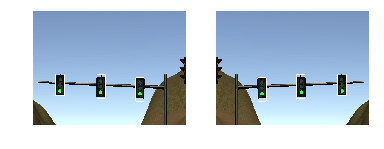

[[(334, 337), (380, 462)], [(536, 353), (581, 476)], [(118, 334), (164, 446)]]
(600, 800, 3)
30


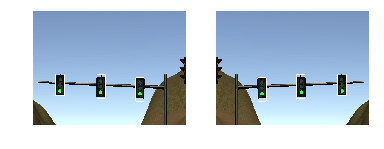

[[(334, 337), (380, 462)], [(536, 353), (581, 476)], [(118, 334), (164, 446)]]
(600, 800, 3)
30


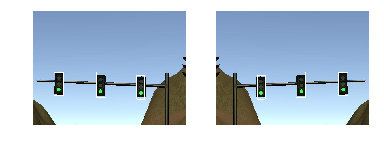

[[(542, 341), (584, 465)], [(332, 324), (381, 457)], [(110, 325), (159, 447)]]
(600, 800, 3)
30


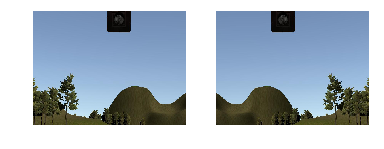

[]
(600, 800, 3)
30


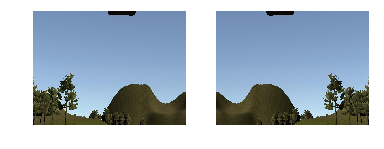

[]
(600, 800, 3)
30


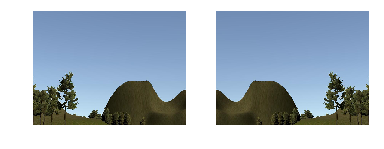

[]
(600, 800, 3)
30


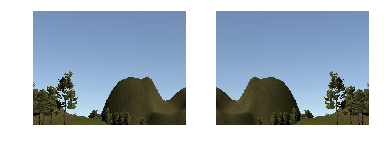

[]
(600, 800, 3)
30


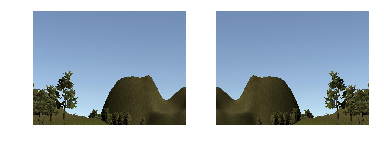

[]
(600, 800, 3)
30


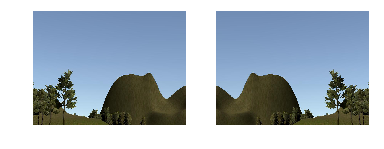

[]
(600, 800, 3)
30


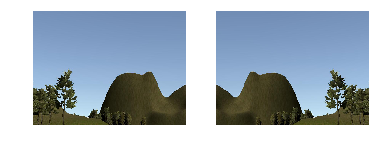

[]
(600, 800, 3)
30


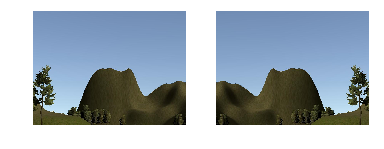

[]
(600, 800, 3)
30


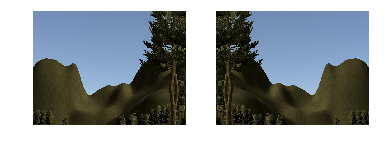

[]
(600, 800, 3)
30


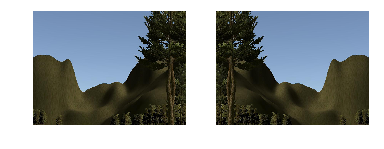

[]
(600, 800, 3)
30


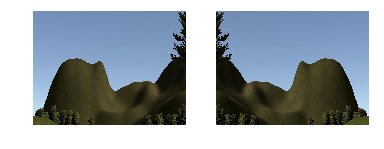

[]
(600, 800, 3)
30


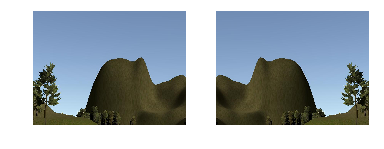

[]
(600, 800, 3)
30


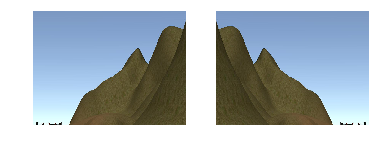

[]
(600, 800, 3)
30


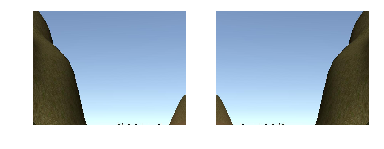

[]
(600, 800, 3)
30


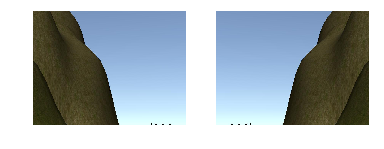

[]
(600, 800, 3)
30


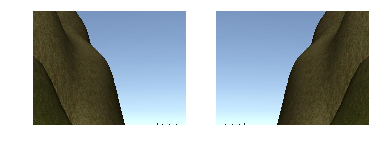

[]
(600, 800, 3)
30


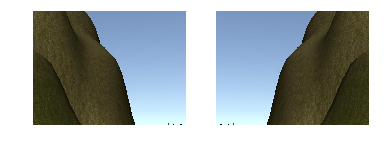

[]
(600, 800, 3)
30


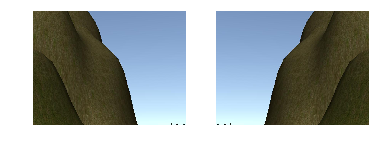

[]
(600, 800, 3)
30


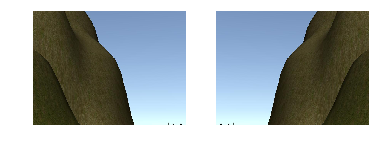

[]
(600, 800, 3)
30


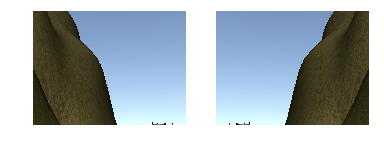

[]
(600, 800, 3)
30


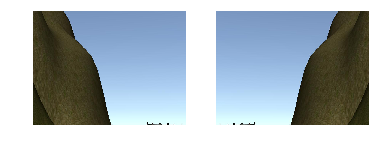

[]
(600, 800, 3)
30


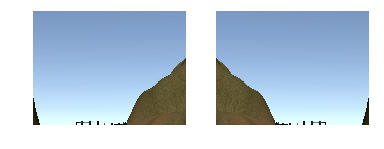

[]
(600, 800, 3)
30


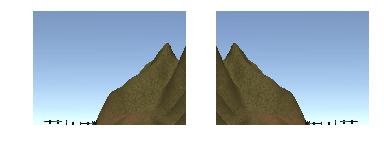

[]
(600, 800, 3)
30


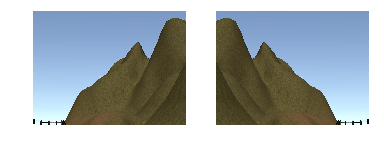

[]
(600, 800, 3)
30


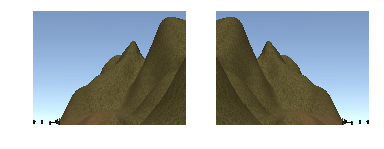

[]
(600, 800, 3)
30


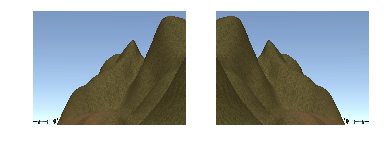

[]
(600, 800, 3)
30


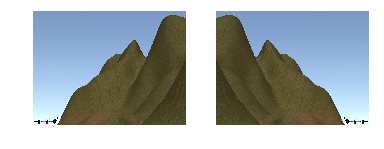

[[(25, 571), (38, 600)]]
(600, 800, 3)
30


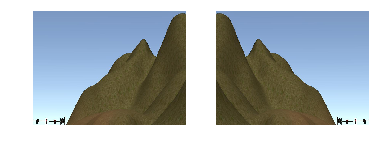

[[(64, 567), (78, 596)]]
(600, 800, 3)
30


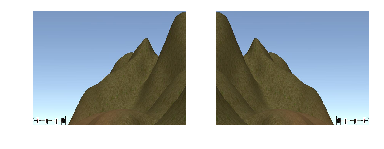

[[(66, 564), (79, 595)], [(116, 565), (129, 597)], [(15, 560), (29, 592)]]
(600, 800, 3)
30


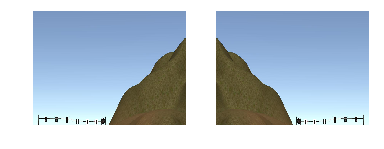

[[(231, 568), (241, 595)], [(280, 570), (290, 597)], [(327, 572), (338, 600)]]
(600, 800, 3)
30


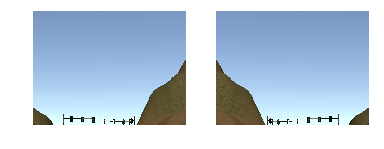

[[(369, 566), (381, 598)], [(419, 574), (429, 599)]]
(600, 800, 3)
30


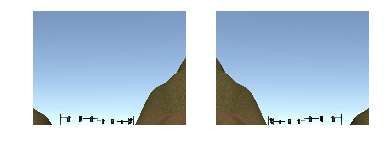

[[(358, 565), (371, 596)], [(412, 567), (424, 599)], [(459, 572), (470, 600)]]
(600, 800, 3)
30


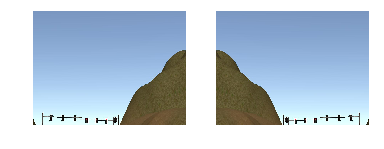

[[(277, 563), (289, 594)], [(326, 564), (339, 595)], [(376, 565), (389, 597)]]
(600, 800, 3)
30


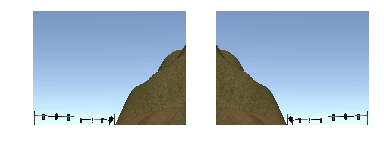

[[(244, 558), (256, 579)], [(355, 561), (366, 594)], [(306, 561), (317, 592)], [(246, 561), (260, 589)], [(306, 558), (318, 582)]]
(600, 800, 3)
30


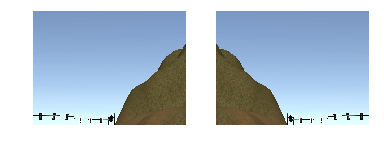

[[(240, 558), (253, 582)], [(350, 558), (363, 591)], [(242, 559), (255, 590)], [(295, 561), (306, 590)]]
(600, 800, 3)
30


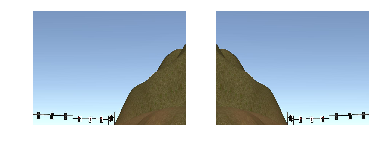

[[(239, 555), (252, 583)], [(350, 554), (364, 584)], [(296, 558), (307, 581)], [(293, 560), (304, 588)]]
(600, 800, 3)
30


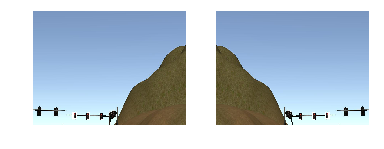

[[(355, 536), (371, 570)], [(281, 533), (296, 570)], [(205, 534), (220, 565)], [(212, 532), (227, 566)]]
(600, 800, 3)
30


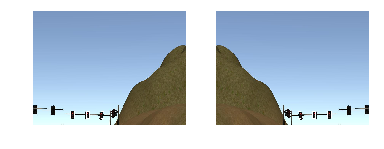

[[(354, 529), (370, 566)], [(278, 529), (295, 567)], [(195, 527), (215, 563)]]
(600, 800, 3)
30


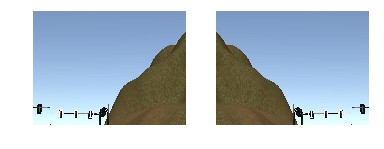

[[(139, 525), (155, 562)], [(216, 524), (233, 563)], [(299, 526), (317, 559)], [(293, 527), (307, 561)], [(140, 520), (155, 553)]]
(600, 800, 3)
30


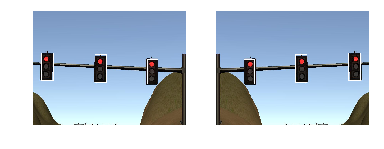

[[(45, 223), (106, 368)], [(323, 232), (383, 379)], [(597, 257), (653, 385)]]
(600, 800, 3)
30


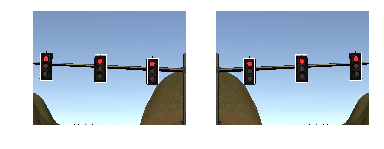

[[(38, 223), (103, 367)], [(324, 231), (383, 377)], [(598, 252), (657, 385)]]
(600, 800, 3)
30


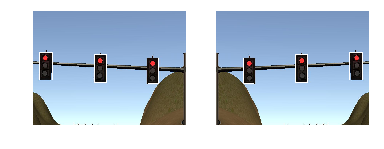

[[(33, 221), (100, 364)], [(321, 232), (383, 378)], [(601, 251), (657, 383)]]
(600, 800, 3)
30


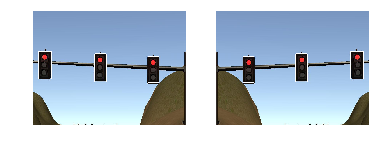

[[(322, 227), (383, 375)], [(28, 215), (96, 360)], [(601, 242), (658, 377)]]
(600, 800, 3)
30


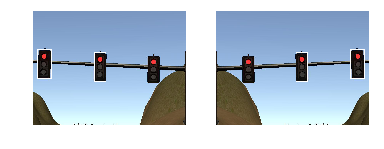

[[(321, 222), (382, 372)], [(22, 205), (96, 356)], [(605, 239), (659, 375)]]
(600, 800, 3)
30


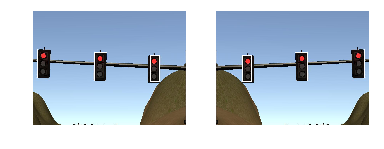

[[(321, 220), (387, 370)], [(22, 203), (88, 354)], [(613, 238), (662, 374)]]
(600, 800, 3)
30


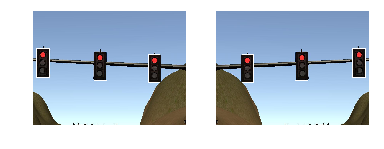

[[(17, 201), (87, 353)], [(319, 214), (386, 367)], [(602, 231), (663, 377)]]
(600, 800, 3)
30


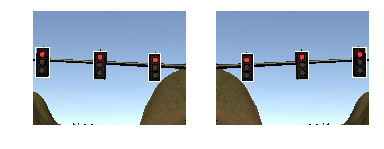

[[(13, 194), (85, 353)], [(317, 215), (387, 365)], [(604, 227), (667, 374)]]
(600, 800, 3)
30


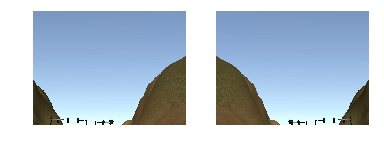

[[(274, 578), (284, 600)], [(320, 579), (331, 600)]]
(600, 800, 3)
30


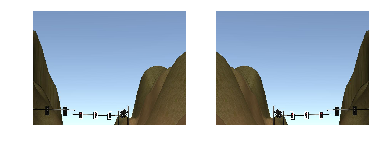

[[(321, 530), (336, 567)], [(395, 530), (412, 567)], [(240, 531), (258, 566)]]
(600, 800, 3)
30


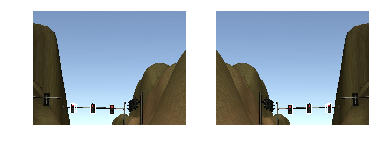

[[(398, 491), (423, 544)], [(301, 490), (326, 540)], [(195, 487), (215, 537)], [(203, 493), (228, 537)]]
(600, 800, 3)
30


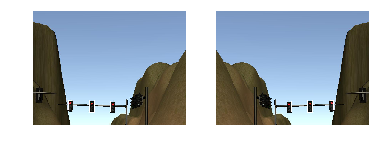

[[(185, 472), (204, 521)], [(296, 468), (322, 534)], [(405, 475), (429, 531)]]
(600, 800, 3)
30


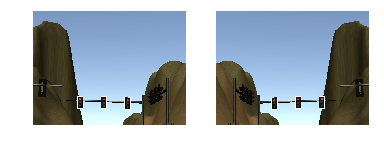

[[(479, 454), (509, 518)], [(355, 451), (384, 514)], [(232, 451), (262, 514)]]
(600, 800, 3)
30


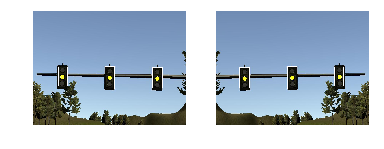

[[(132, 296), (179, 396)], [(376, 295), (427, 411)], [(624, 300), (677, 406)]]
(600, 800, 3)
30


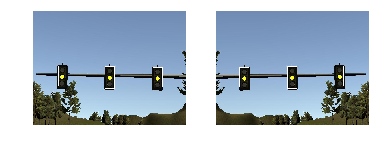

[[(375, 294), (427, 408)], [(132, 291), (177, 396)], [(626, 300), (677, 401)]]
(600, 800, 3)
30


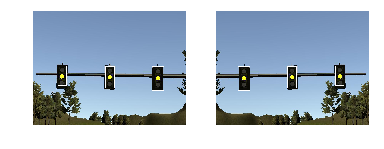

[[(131, 291), (175, 392)], [(378, 295), (427, 406)], [(622, 293), (684, 419)]]
(600, 800, 3)
30


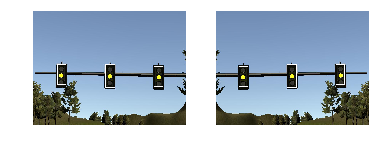

[[(378, 285), (428, 403)], [(633, 293), (680, 399)], [(127, 285), (172, 389)]]
(600, 800, 3)
30


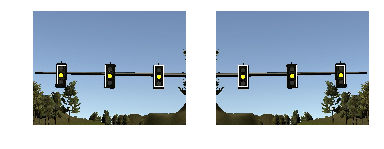

[[(378, 286), (428, 402)], [(636, 288), (681, 400)], [(128, 288), (172, 386)]]
(600, 800, 3)
30


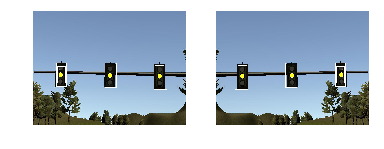

[[(377, 275), (435, 404)], [(638, 290), (685, 397)], [(632, 282), (700, 414)], [(121, 277), (176, 399)], [(127, 295), (170, 380)]]
(600, 800, 3)
30


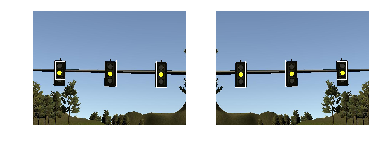

[[(645, 265), (701, 405)], [(375, 261), (437, 401)], [(116, 269), (167, 363)]]
(600, 800, 3)
30


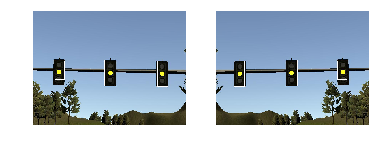

[[(373, 260), (438, 397)], [(114, 266), (163, 363)], [(651, 265), (706, 399)]]
(600, 800, 3)
30


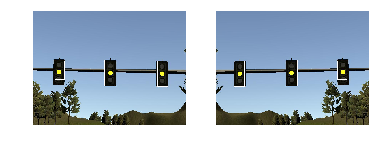

[[(373, 260), (438, 397)], [(114, 266), (163, 363)], [(651, 265), (706, 399)]]
(600, 800, 3)
30


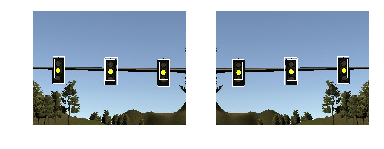

[[(652, 259), (714, 399)], [(374, 248), (441, 391)], [(104, 243), (164, 382)], [(113, 255), (157, 355)], [(661, 270), (705, 361)], [(379, 257), (429, 368)]]
(600, 800, 3)
30


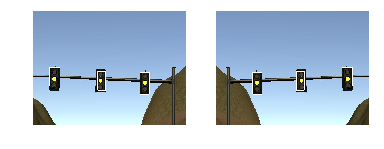

[[(338, 320), (380, 419)], [(559, 326), (608, 439)], [(85, 301), (141, 397)]]
(600, 800, 3)
30


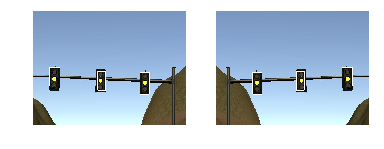

[[(338, 320), (380, 419)], [(559, 326), (608, 439)], [(85, 301), (141, 397)]]
(600, 800, 3)
30


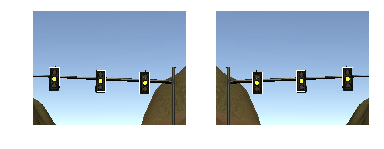

[[(334, 314), (380, 425)], [(556, 324), (610, 437)], [(83, 301), (138, 395)]]
(600, 800, 3)
30


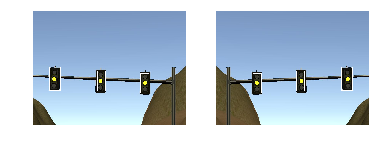

[[(336, 318), (380, 422)], [(561, 331), (605, 433)], [(85, 297), (143, 421)]]
(600, 800, 3)
30


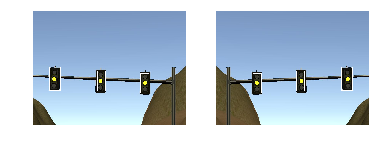

[[(336, 318), (380, 422)], [(561, 331), (605, 433)], [(85, 297), (143, 421)]]
(600, 800, 3)
30


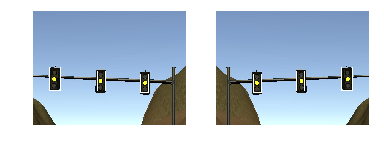

[[(336, 318), (380, 422)], [(562, 333), (604, 430)], [(85, 297), (143, 420)]]
(600, 800, 3)
30


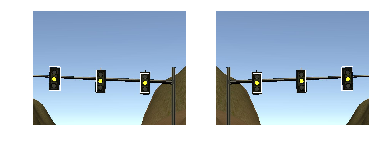

[[(332, 313), (382, 428)], [(561, 332), (605, 431)], [(84, 295), (142, 421)]]
(600, 800, 3)
30


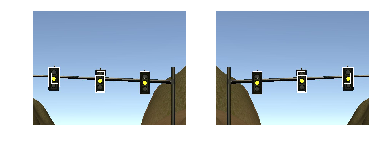

[[(558, 321), (607, 437)], [(82, 300), (138, 401)], [(325, 341), (377, 430)], [(335, 321), (373, 426)], [(96, 329), (131, 382)]]
(600, 800, 3)
30


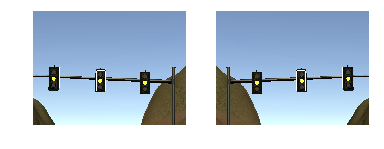

[[(559, 323), (606, 438)], [(333, 316), (378, 423)], [(83, 296), (138, 406)]]
(600, 800, 3)
30


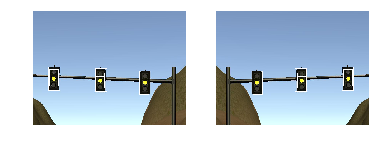

[[(557, 317), (607, 441)], [(87, 309), (132, 397)], [(340, 329), (373, 407)], [(326, 306), (386, 426)], [(81, 296), (141, 420)], [(325, 346), (377, 426)]]
(600, 800, 3)
30


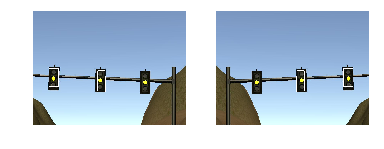

[[(560, 322), (605, 432)], [(84, 305), (133, 400)], [(338, 316), (377, 423)], [(324, 343), (379, 428)]]
(600, 800, 3)
30


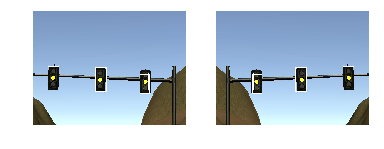

[[(79, 295), (135, 407)], [(569, 328), (604, 418)], [(560, 337), (609, 434)], [(325, 301), (385, 425)]]
(600, 800, 3)
30


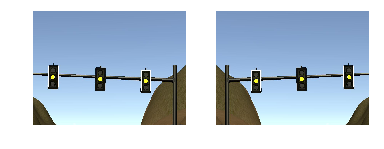

[[(80, 292), (134, 401)], [(566, 314), (615, 423)]]
(600, 800, 3)
30


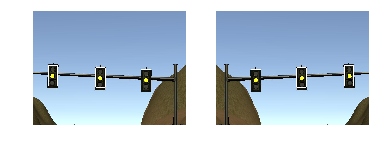

[[(81, 289), (129, 396)], [(327, 301), (378, 403)], [(564, 310), (617, 422)]]
(600, 800, 3)
30


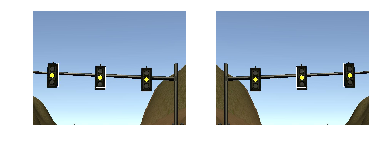

[[(328, 298), (378, 404)], [(79, 275), (132, 402)], [(560, 296), (626, 418)]]
(600, 800, 3)
30


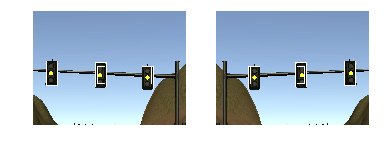

[[(338, 293), (376, 384)], [(579, 298), (619, 386)], [(327, 273), (383, 402)], [(71, 265), (128, 393)], [(569, 293), (629, 411)]]


In [11]:
read_annotations = pickle.load(open(PATH_TO_ROOT + '/annotation_pipeline/' + 'annotations' + '.p', 'rb'))
filtered_annotations = []
for i in range(0,len(read_annotations)):
    filtered_annotations.append(filter_annotations(read_annotations[i], str(PATH_TO_TEST_IMAGES_DIR),show_image=True))

In [12]:
def add_brightness(image):    
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS    
    image_HLS = np.array(image_HLS, dtype = np.float64)     
    random_brightness_coefficient = np.random.uniform()+0.5 ## generates value between 0.5 and 1.5    
    brightness_coefficient = 1.2
    image_HLS[:,:,1] = image_HLS[:,:,1]*brightness_coefficient ## scale pixel values up or down for channel 1(Lightness)    
    image_HLS[:,:,1][image_HLS[:,:,1]>255]  = 255 ##Sets all values above 255 to 255    
    image_HLS = np.array(image_HLS, dtype = np.uint8)    
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB    
    return image_RGB

def generate_random_lines(imshape,slant,drop_length):    
    drops=[]    
    for i in range(1500): ## If You want heavy rain, try increasing this        
        if slant<0:            
            x= np.random.randint(slant,imshape[1])        
        else:            
            x= np.random.randint(0,imshape[1]-slant)        
        y= np.random.randint(0,imshape[0]-drop_length)        
        drops.append((x,y))    
    return drops            

def add_rain(image):        
    image = image.copy()
    imshape = image.shape    
    slant_extreme=10    
    slant= np.random.randint(-slant_extreme,slant_extreme)     
    drop_length=20    
    drop_width=2 
    drop_color=(200,200,200) 
    ## a shade of gray    
    rain_drops= generate_random_lines(imshape,slant,drop_length)        
    for rain_drop in rain_drops:        
        cv2.line(image,(rain_drop[0],rain_drop[1]),(rain_drop[0]+slant,rain_drop[1]+drop_length),drop_color,drop_width)    
    image= cv2.blur(image,(7,7)) ## rainy view are blurry        
    brightness_coefficient = 0.7 ## rainy days are usually shady     
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS    
    image_HLS[:,:,1] = image_HLS[:,:,1]*brightness_coefficient ## scale pixel values down for channel 1(Lightness)    
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB    
    return image_RGB

def generate_shadow_coordinates(imshape, no_of_shadows=1):    
    vertices_list=[]    
    for index in range(no_of_shadows):        
        vertex=[]        
        for dimensions in range(np.random.randint(3,15)): ## Dimensionality of the shadow polygon            
            vertex.append(( imshape[1]*np.random.uniform(),imshape[0]//3+imshape[0]*np.random.uniform()))        
            vertices = np.array([vertex], dtype=np.int32) ## single shadow vertices         
            vertices_list.append(vertices)
    return vertices_list ## List of shadow vertices


def add_shadow(image,no_of_shadows=1):    
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS    
    mask = np.zeros_like(image)     
    imshape = image.shape    
    vertices_list= generate_shadow_coordinates(imshape, no_of_shadows) #3 getting list of shadow vertices    
    for vertices in vertices_list:         
        cv2.fillPoly(mask, vertices, 255) ## adding all shadow polygons on empty mask, single 255 denotes only red channel        
    image_HLS[:,:,1][mask[:,:,0]==255] = image_HLS[:,:,1][mask[:,:,0]==255]*7   ## if red channel is hot, image's "Lightness" channel's brightness is lowered     
    image_HLS[:,:,1][image_HLS[:,:,1]>255]  = 255 ##Sets all values above 255 to 255 
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB    
    return image_RGB

def augmentData(original_image):
    
    blured_image = cv2.GaussianBlur(original_image,(15,15),0)
    image_with_random_noise = np.uint8(util.random_noise(original_image)*255)
    image_with_random_noise[image_with_random_noise > 255]  = 255
    image_with_random_noise[image_with_random_noise < 0]  = 0
    image_with_random_noise = np.uint8(image_with_random_noise)
    v_min, v_max = np.percentile(original_image, (0.2, 99.8))
    better_contrast = exposure.rescale_intensity(original_image, in_range=(v_min, v_max))
    bright_image = add_brightness(original_image)
    rainy_image = add_rain(original_image)
    shadowed_image = add_shadow(original_image,no_of_shadows=1)
    
    return [original_image, blured_image, image_with_random_noise, bright_image, rainy_image]

In [13]:
def select_list(probability, choice, alternative_choice):
    if (random() <= probability):
        return choice
    else:
        return alternative_choice

def make_cvs_file(annotations, output_path, test_partition = 0.15):
    
    print("---> ", output_path)
    annotation_lists = {}
    annotation_lists["train"] = []
    annotation_lists["test"] = []
    counter = 0
    for i in range(len(annotations)):
        counter += 1
        fname = str(counter).zfill(5)
        
        image = plt.imread(annotations[i]["file_name"])
        
        width = image.shape[1]
        height = image.shape[0]
        class_name = annotations[i]["color"]
        class_no   = 0
        if (class_name == "red"):
            class_no = 1
        elif (class_name == "yellow"):
            class_no = 2
        elif (class_name == "green"):
            class_no = 3
        
        boxes = annotations[i]["boxes"]
        flipped_boxes = annotations[i]["flipped_boxes"]
        
        if (len(boxes) > 0):
            images = augmentData(image)
            
            selection = select_list(test_partition, "test", "train")
            filename = output_path + "/images/" + selection + "/" + fname + "_o_rigal" + ".jpg"
            plt.imsave(filename, images[0], format="jpg")
            for box in boxes:
                annotation_lists[selection].append((filename, width, height, class_name, class_no, \
                                          box[0][0], box[0][1], box[1][0], box[1][1]))
            selection = select_list(test_partition, "test", "train")
            filename = output_path + "/images/" + selection + "/" + fname + "_o_blure" + ".jpg"
            plt.imsave(filename, images[1], format="jpg")
            for box in boxes:
                annotation_lists[selection].append((filename, width, height, class_name, class_no, \
                                          box[0][0], box[0][1], box[1][0], box[1][1]))
            selection = select_list(test_partition, "test", "train")
            filename = output_path + "/images/" + selection + "/" + fname + "_o_noise" + ".jpg"
            plt.imsave(filename, images[2], format="jpg")
            for box in boxes:
                annotation_lists[selection].append((filename, width, height, class_name, class_no, \
                                          box[0][0], box[0][1], box[1][0], box[1][1]))
            selection = select_list(test_partition, "test", "train")
            filename = output_path + "/images/" + selection + "/" + fname + "_o_brght" + ".jpg"
            plt.imsave(filename, images[3], format="jpg")
            for box in boxes:
                annotation_lists[selection].append((filename, width, height, class_name, class_no, \
                                          box[0][0], box[0][1], box[1][0], box[1][1]))
            selection = select_list(test_partition, "test", "train")
            filename = output_path + "/images/" + selection + "/" + fname + "_o_rainy" + ".jpg"
            plt.imsave(filename, images[4], format="jpg")
            for box in boxes:
                annotation_lists[selection].append((filename, width, height, class_name, class_no, \
                                          box[0][0], box[0][1], box[1][0], box[1][1]))

            images = augmentData(cv2.flip(image, 1))
            selection = select_list(test_partition, "test", "train")
            filename = output_path + "/images/" + selection + "/" + fname + "_f_lippd" + ".jpg"
            plt.imsave(filename, images[0], format="jpg")
            for box in boxes:
                annotation_lists[selection].append((filename, width, height, class_name, class_no, \
                                          box[0][0], box[0][1], box[1][0], box[1][1]))
            selection = select_list(test_partition, "test", "train")
            filename = output_path + "/images/" + selection + "/" + fname + "_f_blure" + ".jpg"
            plt.imsave(filename, images[1], format="jpg")
            for box in boxes:
                annotation_lists[selection].append((filename, width, height, class_name, class_no, \
                                          box[0][0], box[0][1], box[1][0], box[1][1]))
            selection = select_list(test_partition, "test", "train")
            filename = output_path + "/images/" + selection + "/" + fname + "_f_noise" + ".jpg"
            plt.imsave(filename, images[2], format="jpg")
            for box in boxes:
                annotation_lists[selection].append((filename, width, height, class_name, class_no, \
                                          box[0][0], box[0][1], box[1][0], box[1][1]))
            selection = select_list(test_partition, "test", "train")
            filename = output_path + "/images/" + selection + "/" + fname + "_f_brght" + ".jpg"
            plt.imsave(filename, images[3], format="jpg")
            for box in boxes:
                annotation_lists[selection].append((filename, width, height, class_name, class_no, \
                                          box[0][0], box[0][1], box[1][0], box[1][1]))
            selection = select_list(test_partition, "test", "train")
            filename = output_path + "/images/" + selection + "/" + fname + "_f_rainy" + ".jpg"
            plt.imsave(filename, images[4], format="jpg")
            for box in boxes:
                annotation_lists[selection].append((filename, width, height, class_name, class_no, \
                                          box[0][0], box[0][1], box[1][0], box[1][1]))

    
    column_name = ['filename', 'width', 'height',
                'class_name', 'class_no', 'xmin', 'ymin', 'xmax', 'ymax']
    training_data_frame = pd.DataFrame(annotation_lists["train"], columns=column_name)
    training_data_frame.to_csv(output_path + "/train_annotation_list.csv")
    test_data_frame = pd.DataFrame(annotation_lists["test"], columns=column_name)
    test_data_frame.to_csv(output_path + "/test_annotation_list.csv")
    return test_data_frame, training_data_frame

In [14]:
test_df, training_df = make_cvs_file(filtered_annotations, PATH_TO_ROOT + 'annotation_pipeline')

--->  C:/Users/saidz/git/CarND-Capstone/tl_detection_pipeline/annotation_pipeline


In [15]:
!python ./annotation_pipeline/generate_tfrecord.py --csv_input=./annotation_pipeline/train_annotation_list.csv  --output_path=./annotations/train.record
!python ./annotation_pipeline/generate_tfrecord.py --csv_input=./annotation_pipeline/test_annotation_list.csv   --output_path=./annotations/test.record

Successfully created the TFRecords: C:\Users\saidz\git\CarND-Capstone\tl_detection_pipeline\./annotations/train.record
Successfully created the TFRecords: C:\Users\saidz\git\CarND-Capstone\tl_detection_pipeline\./annotations/test.record


In [ ]:
!python c:/users/saidz/tensorflow/models/research/object_detection/train.py --pipeline_config_path=./pretrained/train_config/faster_rcnn-traffic-udacity_sim.config --train_dir=./training